In [1]:
import datetime

import pandas as pd
import spacy
import re
import string
import numpy as np

from matplotlib import cm
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
%matplotlib inline

from spacy.tokens import Token
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import gensim
from gensim import corpora, models
from gensim.models.phrases import Phrases, Phraser
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models.coherencemodel import CoherenceModel

import pyLDAvis.gensim
pyLDAvis.enable_notebook()
from ipywidgets import interact

import nltk
from nltk.corpus import stopwords

from sklearn.decomposition import PCA

from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score

import enchant
pd.set_option('display.max_rows', 500)

/Users/balaji/anaconda3/lib/python3.7/site-packages/nltk/decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
/Users/balaji/anaconda3/lib/python3.7/site-packages/nltk/lm/counter.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, defaultdict


In [2]:
dict_check = enchant.Dict("en_US")

#### Importing the file ####
Path="src/"
Filename='projects_Preprocessed.csv'
df=pd.read_csv(Path+Filename)

Cat_File="category_hier.csv"
Cat_data=pd.read_csv(Path+Cat_File)

varcluster_file="variable_clusters.csv"
varcluster=pd.read_csv(Path+varcluster_file)

manualtag=pd.read_csv(Path+'SamplesManualTagger.csv')


varcluster_info=pd.read_csv(Path+'variable_clusters_info_v2.csv')

df=df[df['Translates']!="The goal of the Heisenberg Program is to enable outstanding scientists who fulfill all the requirements for a long-term professorship to prepare for a scientific leadership role and to work on further research topics during this time. In pursuing this goal, it is not always necessary to choose and implement project-based procedures. For this reason, in the submission of applications and later in the preparation of final reports - unlike other support instruments - no 'summary' of project descriptions and project results is required. Thus, such information is not provided in GEPRIS."]

## Filtering the null abstracts & short description
df=df[(pd.isnull(df.PreProcessedDescription)==False) & (df.PreProcessedDescription.str.strip()!='abstract available')& (df.PreProcessedDescription.str.len()>100) & (pd.isnull(df["SubjectArea"])==False)]

# Striping the category column
Cat_data.Category=Cat_data.Category.str.strip()

## Merging the high level category information

df=df.merge(Cat_data[["File_Categories","Category"]], how="left", left_on="SubjectArea", right_on="File_Categories")


In [3]:
#dummies=pd.get_dummies(merged_data['Category'])
#merged_data=pd.concat([merged_data,dummies], axis=1,ignore_index=False)

In [4]:
df.columns

Index(['Name', 'SubUrl', 'FundingFrom', 'FundingEnd', 'SubjectArea',
       'Institution', 'Description', 'Translates', 'Name_Translated',
       'PreProcessedDescription', 'File_Categories', 'Category'],
      dtype='object')

In [23]:
df['length']=[len([x for x in str(i).split()]) for i in df.PreProcessedDescription]

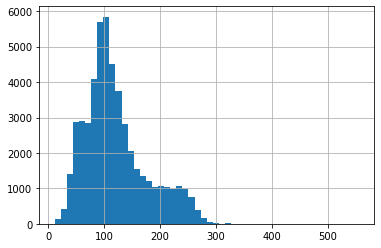

In [30]:
df['length'].hist(bins=50)

In [22]:
pd.Series(freq_words).value_counts().reset_index().sort_values('index')

,index,0
287,11,2
316,12,1
264,13,11
270,14,7
265,15,11
260,16,14
262,17,13
251,18,22
254,19,18
263,20,13


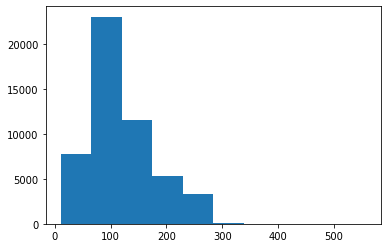

In [14]:
plt.hist(freq_words,bins=10);

In [5]:
# TF IDF Conversion

vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
review_vectors = vectorizer.fit_transform(df["PreProcessedDescription"])
features_df = pd.DataFrame(review_vectors.toarray(), columns = vectorizer.get_feature_names())

features_df.reset_index(drop=True, inplace=True)
df.reset_index(drop=True, inplace=True)
merged_data=pd.concat([df,features_df], axis=1,ignore_index=False)

#wordslist=merged_data.columns.tolist()[len(df.columns)+6:]

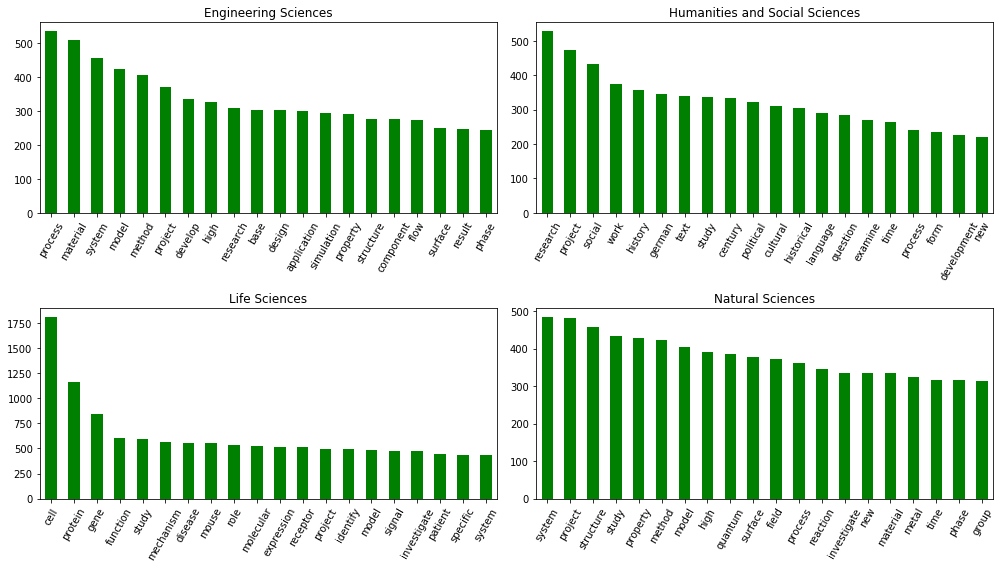

In [6]:
wordslist=merged_data.columns.tolist()[len(df.columns)+2:]

plt.subplots(figsize=(14,8)) 
i=1
for cat,bucket in merged_data.groupby('Category'):
    
    plt.subplot(2,2,i)
    bucket[wordslist].sum().sort_values(ascending=False).head(20).plot(kind='bar',color='green')
    plt.title(cat)
    plt.xticks(rotation=60)
    
    i=i+1
    plt.tight_layout()

In [21]:
## Removing the General cluster columns
merged_data=merged_data.drop(columns=merged_data.columns[merged_data.columns.isin(varcluster[varcluster.category=='General'].Variable)])

In [22]:
## Removing the columns that are far away from of cluster
merged_data=merged_data.drop(columns=merged_data.columns[merged_data.columns.isin(varcluster[varcluster.RS_Ratio>=1].Variable)])

In [122]:
pca = pd.DataFrame(PCA(n_components=10).fit_transform(merged_data[cols][merged_data.Category==cats]))
#concated_ds=pd.concat([pd.DataFrame(pca),merged_data], ignore_index=True, axis=1)
#concated_ds.columns=['PCA_1','PCA_2']+merged_data.columns.tolist()
#merged_data=concated_ds

In [162]:
#cats='Humanities and Social Sciences'
for cats in merged_data.Category.unique():
    print(cats, ': ')
    for ps in np.linspace(3,10,3, dtype=int):
        pca =PCA(n_components=ps)
        pca_data= pd.DataFrame(pca.fit_transform(merged_data[cols][merged_data.Category==cats]))

        print('  PCA components :',ps,'Variance coveragence' ,np.max(pca.explained_variance_ratio_.cumsum())*100)

        KmeansCluster1=merged_data[cols2][merged_data.Category==cats]

        range_n_clusters=range(2,8)
        for n_clusters in range_n_clusters:
            MiniBatchKMeans(n_clusters=n_clusters)
            clusterer = MiniBatchKMeans(n_clusters=n_clusters)
            preds = clusterer.fit_predict(pca_data)
            centers = clusterer.cluster_centers_

            score = silhouette_score (pca_data, preds, metric='euclidean')
            print("    For n_clusters = {}, silhouette score is {}, Density {})".format(n_clusters, score,pd.Series(preds).value_counts().tolist()))

Engineering Sciences : 
  PCA components : 3 Variance coveragence 4.950688969237124
    For n_clusters = 2, silhouette score is 0.29965634842486555, Density [4783, 4627])
    For n_clusters = 3, silhouette score is 0.33328081190107867, Density [4301, 3737, 1372])
    For n_clusters = 4, silhouette score is 0.38919531958266346, Density [4190, 3083, 1302, 835])
    For n_clusters = 5, silhouette score is 0.3074131899646166, Density [3060, 2575, 1547, 1146, 1082])
    For n_clusters = 6, silhouette score is 0.2877763114947296, Density [2404, 2397, 1393, 1362, 1032, 822])
    For n_clusters = 7, silhouette score is 0.28593879572537206, Density [2916, 1956, 1341, 1176, 787, 663, 571])
  PCA components : 6 Variance coveragence 8.207819728538695
    For n_clusters = 2, silhouette score is 0.39704342061629705, Density [9019, 391])
    For n_clusters = 3, silhouette score is 0.22685631973574305, Density [4884, 3032, 1494])
    For n_clusters = 4, silhouette score is 0.23490547741154524, Density

In [165]:
KmeansCluster=merged_data[merged_data.columns[:14]]
#KmeansCluster['DBScanCluster']='';
kmcls={}

cols=merged_data.columns[23:]
cols2=merged_data.columns[:23]

ps=3
nclus=4
cats='Engineering Sciences'
KmeansCluster1=merged_data[cols2][merged_data.Category==cats]
pca =PCA(n_components=ps)
pca_data= pd.DataFrame(pca.fit_transform(merged_data[cols][merged_data.Category==cats]))
KmeansCluster1['KmeanCluster']= MiniBatchKMeans(n_clusters=nclus).fit_predict(pca_data)

#ps=10
#nclus=
cats='Humanities and Social Sciences'
KmeansCluster2=merged_data[cols2][merged_data.Category==cats]
pca =PCA(n_components=ps)
pca_data= pd.DataFrame(pca.fit_transform(merged_data[cols][merged_data.Category==cats]))
KmeansCluster2['KmeanCluster']= MiniBatchKMeans(n_clusters=nclus).fit_predict(pca_data)

#ps=10
#nclus=
cats='Life Sciences'
KmeansCluster3=merged_data[cols2][merged_data.Category==cats]
pca =PCA(n_components=ps)
pca_data= pd.DataFrame(pca.fit_transform(merged_data[cols][merged_data.Category==cats]))
KmeansCluster3['KmeanCluster']= MiniBatchKMeans(n_clusters=nclus).fit_predict(pca_data)

#ps=10
#nclus=
cats='Natural Sciences'
KmeansCluster4=merged_data[cols2][merged_data.Category==cats]
pca =PCA(n_components=ps)
pca_data= pd.DataFrame(pca.fit_transform(merged_data[cols][merged_data.Category==cats]))
KmeansCluster4['KmeanCluster']= MiniBatchKMeans(n_clusters=nclus).fit_predict(pca_data)

NewMergedDSKm=pd.concat([KmeansCluster1,KmeansCluster2,KmeansCluster3,KmeansCluster4])

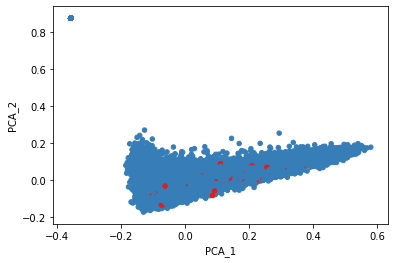

In [166]:
cmap = cm.get_cmap('Set1')
NewMergedDSKm.plot.scatter(x='PCA_1',y='PCA_2', cmap=cmap,c='DBScanCluster', colorbar = False)

In [225]:
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(token)
    return result

def make_bigram(inputlist):
    bigram = Phrases(inputlist, min_count=1, threshold=1,delimiter=b' ')
    bigram_phraser = Phraser(bigram)
    new_list=[]
    for sent in inputlist:
        new_list.append(bigram_phraser[sent])
    return new_list

def buildLDA(processed_docs, ip_num_topics=4):
    dictionary = gensim.corpora.Dictionary(processed_docs)
    dictionary.filter_extremes(no_below=5, no_above=0.1, keep_n=1000)
    print('Dictionary size', len(dictionary.keys()))
    bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

    tfidf = models.TfidfModel(bow_corpus)
    corpus_tfidf = tfidf[bow_corpus]

    lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=ip_num_topics, id2word=dictionary, passes=4, workers=4, 
                                                 eta=[0.001]*len(dictionary.keys()), alpha =.005*ip_num_topics)
    
    return dictionary,bow_corpus,corpus_tfidf, lda_model_tfidf


def LDAtopicSummary(model, displaysubplot=[2,2]):
    for idx, topic in model.print_topics(-1):
        print('Topic: {} Word: {}'.format(idx, topic))
        
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        #print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords',"Text"]
    return(sent_topics_df)


### Engineering Sciences

In [226]:
KmeansCluster2.groupby(['DBScanCluster','KmeanCluster']).count()['Translates']

DBScanCluster  KmeanCluster
-1             0                134
               1                  3
               2                 38
               3                 65
 0             0               5058
               1                461
               2               2838
               3               1619
 1             0                  2
Name: Translates, dtype: int64

In [227]:
clus=0
#docs=make_bigram(KmeansCluster1["PreProcessedDescription"][KmeansCluster1['KmeanCluster']==clus].map(preprocess))
docs=make_bigram(KmeansCluster2["PreProcessedDescription"][KmeansCluster2['DBScanCluster']!=0].map(preprocess))
print(str(len(docs))+' docs in cluster '+str(clus))
dictionary,bow_corpus,corpus_tfidf, lda_model_tfidf =buildLDA(docs , 12)

# Compute Coherence Score using c_v
coherence_model_lda = CoherenceModel(model=lda_model_tfidf, texts=docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

242 docs in cluster 0
Dictionary size 732

Coherence Score:  0.45550558555079596


In [228]:
LDAtopicSummary(lda_model_tfidf)

Topic: 0 Word: 0.008*"state" + 0.007*"crisis" + 0.007*"region" + 0.007*"field" + 0.007*"environment" + 0.007*"determination" + 0.007*"life" + 0.007*"local" + 0.006*"century" + 0.006*"community"
Topic: 1 Word: 0.032*"scale" + 0.018*"company" + 0.018*"expression" + 0.015*"live" + 0.014*"widely" + 0.014*"future" + 0.013*"book" + 0.013*"signal" + 0.012*"objective" + 0.012*"religion"
Topic: 2 Word: 0.016*"student" + 0.013*"class" + 0.013*"language" + 0.012*"control" + 0.011*"help" + 0.011*"indicate" + 0.010*"organization" + 0.010*"professional" + 0.010*"support" + 0.010*"contrary"
Topic: 3 Word: 0.012*"solution" + 0.012*"step" + 0.012*"property" + 0.011*"phase" + 0.011*"diversity" + 0.011*"want" + 0.011*"strong" + 0.010*"space" + 0.010*"control" + 0.010*"specifically"
Topic: 4 Word: 0.017*"christian" + 0.017*"novel" + 0.014*"identify" + 0.014*"woman" + 0.013*"contrast" + 0.013*"methodological" + 0.012*"account" + 0.012*"interpretation" + 0.011*"emergence" + 0.011*"action"
Topic: 5 Word: 0.0

In [229]:
pyLDAvis.gensim.prepare(lda_model_tfidf, bow_corpus, dictionary=lda_model_tfidf.id2word)

/Users/balaji/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.063866  0.076510       1        1  27.691061
7      0.027311 -0.034360       2        1  25.085354
3      0.097898 -0.047833       3        1   9.977681
4     -0.163544  0.062735       4        1   6.327349
9      0.092224 -0.072861       5        1   5.583826
10    -0.213844 -0.174955       6        1   4.777018
2      0.162962 -0.009524       7        1   4.746176
5     -0.125047  0.042200       8        1   4.597919
1     -0.003233 -0.043110       9        1   3.389739
8      0.053574  0.300676      10        1   3.225843
6     -0.035632  0.011191      11        1   2.762244
11     0.171197 -0.110668      12        1   1.835791, topic_info=    Category       Freq                Term      Total  loglift  logprob
432  Default  22.000000          technology  22.000000  30.0000  30.0000
56   Default  26.000000          subproject  26.000000  29.0000  29.0000
54   Default  20.000000                self  20.000000  28.0000  28.0000
325  Default  22.000000               local  22.000000  27.0000  27.0000
270  Default  20.000000       communication  20.000000  26.0000  26.0000
190  Default  19.000000             company  19.000000  25.0000  25.0000
483  Default  31.000000      transformation  31.000000  24.0000  24.0000
310  Default  23.000000              object  23.000000  23.0000  23.0000
98   Default  21.000000           discourse  21.000000  22.0000  22.0000
429  Default  10.000000               scale  10.000000  21.0000  21.0000
458  Default  21.000000              relate  21.000000  20.0000  20.0000
645  Default  17.000000               actor  17.000000  19.0000  19.0000
282  Default  32.000000        organization  32.000000  18.0000  18.0000
287  Default  19.000000             service  19.000000  17.0000  17.0000
81   Default  22.000000               shape  22.000000  16.0000  16.0000
424  Default  20.000000            economic  20.000000  15.0000  15.0000
237  Default  27.000000              action  27.000000  14.0000  14.0000
425  Default  14.000000              future  14.000000  13.0000  13.0000
291  Default  17.000000                type  17.000000  12.0000  12.0000
323  Default  17.000000         integration  17.000000  11.0000  11.0000
267  Default  25.000000         theoretical  25.000000  10.0000  10.0000
331  Default  16.000000              signal  16.000000   9.0000   9.0000
82   Default  25.000000               space  25.000000   8.0000   8.0000
487  Default  21.000000             culture  21.000000   7.0000   7.0000
638  Default  11.000000               urban  11.000000   6.0000   6.0000
160  Default  14.000000               brain  14.000000   5.0000   5.0000
151  Default  18.000000              modern  18.000000   4.0000   4.0000
496  Default  22.000000          difference  22.000000   3.0000   3.0000
678  Default  11.000000               arise  11.000000   2.0000   2.0000
221  Default  16.000000      interpretation  16.000000   1.0000   1.0000
556   Topic1   6.952462             respond   7.193047   1.2500  -5.7924
14    Topic1   9.570551             writing   9.921496   1.2480  -5.4728
712   Topic1  13.341640             analyse  13.847467   1.2468  -5.1406
518   Topic1   8.799414      archaeological   9.177192   1.2420  -5.5568
281   Topic1   6.652279             limited   6.966665   1.2379  -5.8365
471   Topic1   9.239762                draw   9.705948   1.2348  -5.5080
478   Topic1   7.072992             operate   7.432327   1.2345  -5.7752
4     Topic1   8.638541              differ   9.124854   1.2293  -5.5752
22    Topic1   8.748249           reasoning   9.254908   1.2278  -5.5626
623   Topic1   6.005049             promise   6.357979   1.2270  -5.9389
382   Topic1  10.308818            colonial  10.934174   1.2252  -5.3985
384   Topic1   9.247527         dissolution   9.864100   1.2195  -5.5071
488   Topic1  10.122589              speech  10.852761   1.214

In [231]:
def demo(title):
    if not np.isnan(title):
        return([" ".join(i) for i in df_dominant_topic["Text"][df_dominant_topic["Dominant_Topic"]==title-1].tolist()][:5])

df_dominant_topic = format_topics_sentences(lda_model_tfidf,bow_corpus,list(docs) )
df_dominant_topic["DBScanCluster"]=KmeansCluster2["DBScanCluster"][KmeansCluster2['DBScanCluster']!=0].tolist()
interact(demo, title=np.sort(df_dominant_topic["Dominant_Topic"].unique())+1);

interactive(children=(Dropdown(description='title', options=(1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0…

In [ ]:
df_dominant_topic['Dominant_Topic'][df_dominant_topic['DBScanCluster']!=0].value_counts()